<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/dgmm_em.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import scipy.stats as stats ## for mvn
from sklearn.cluster import KMeans
import seaborn as sns

from scipy.stats import norm, multivariate_normal

In [2]:
def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False
        
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

In [3]:
class DGMM(object):
  
  def __init__(self, X, c=3):
    self.X = np.asarray(X)
    
    # dimension
    self.n, self.p = X.shape
    self.c = c
  
#  def _init(self):
#    self.r_i = torch.ones(self.n)
#    self.r_ij = torch.ones(self.c, self.n)
#    self.r_ijk = torch.ones(self.c, self.c, self.n)

#    self.n_c = torch.zeros(self.c)
#    self.n_cc = torch.zeros(self.c)

#    self.pi_d = torch.zeros(1)
    #self.pi_c = torch.ones(self.c) / self.c
    #self.pi_cc = torch.triu(torch.ones(self.c, self.c)) / (self.c * self.c)

#    self.pi_c = torch.zeros(self.c)
#    self.pi_cc = torch.ones(self.c, self.c)

#    self.mu_c = torch.zeros(self.c, self.p)
#    self.co_c = torch.zeros(self.c, self.p, self.p)
  
  def _kminit(self):
    
    kmeans = KMeans(n_clusters=self.c, random_state=0).fit(self.X)
    self.mu_c = torch.tensor(kmeans.cluster_centers_)

    self.n_c = torch.zeros(self.c)
    self.co_c = torch.zeros(self.c, self.p, self.p)
    
    for j in range(self.c):
      indx = kmeans.labels_ == j
      d = self.X[indx]
      self.n_c[j] = sum(indx)
      self.co_c[j] = torch.from_numpy(np.cov(d.T))
    
    #self.n_c = torch.tensor([38., 50., 62.])
    self.n_cc = torch.tensor([[10, 20, 30], [0, 15, 40], [0, 0, 35]])

    self.pi_d = .4
    self.pi_c = self.n_c/sum(self.n_c)
    self.pi_cc = self.n_cc/torch.sum(self.n_cc)  

    self.r_i = torch.ones(self.n)
    self.r_ij = torch.ones(self.c, self.n)
    self.r_ijk = torch.ones(self.c, self.c, self.n)
  
  def _init(self):
    self.n_c = torch.ones(self.c) #torch.tensor([38., 50., 62.])
    self.n_cc =  torch.ones(self.c, self.c) #torch.tensor([[10, 20, 30], [0, 15, 40], [0, 0, 35]])

    self.r_i = torch.ones(self.n)
    self.r_ij = torch.ones(self.c, self.n)
    self.r_ijk = torch.ones(self.c, self.c, self.n)

    #self.muj = torch.zeros(self.c, self.p)
    #self.coj = torch.zeros(self.c, self.p, self.p)

  def _uinit(self, pid, pic, picc, mu, co):
    
    self.pi_d = pid #.4
    self.pi_c = pic 
    self.pi_cc = picc

    self.mu_c = mu #torch.tensor(kmeans.cluster_centers_)
    self.co_c = co #torch.zeros(self.c, self.p, self.p)

  def train(self, pid, pic, picc, mu, co, itermax=500, tot=1e-5):
    
    self._init()
    self._uinit(pid, pic, picc, mu, co) ## need work
    
    llv = [0.0]
    for iter in range(itermax):
      #print("p1")
      lli = self.estep()

      #print("p2")
      self.mstep()
      #print("p3")
      
      print('Iteration', iter + 1, 'Likelihood: ', lli)
        
      if abs(llv[-1] - lli) < tot:
        break 
      
      llv.append(lli)
    return llv[1:]

  def estep(self):

    ### E-step:
    ## input: n, p, c, pi_d, pi_c, pi_cc, mu_c, co_c
    ## output: r_i, r_ij, r_ijk, ll
    ## calculate 1) pi_i => d; 2) pi_j => z; 3) pi_jk => gamma
    ## first compute 2) and 3) and then 1)

    r_ij_top = torch.zeros(self.c, self.n)
    r_ijk_top = torch.zeros(self.c, self.c, self.n)
    
    for j in range(self.c):

      #print(j)
      #print("jb")
      #print(self.mu_c[j]) 
      #print(self.co_c[j])
      #print(stats.multivariate_normal(self.mu_c[j], self.co_c[j]).pdf(self.X))
      r_ij_top[j] = self.pi_d * (self.pi_c[j] * stats.multivariate_normal(self.mu_c[j], self.co_c[j]).pdf(self.X))
      #print("ja")

      #print(self.co_c[j])
      #print(self.mu_c[j])
      #print(stats.multivariate_normal(self.mu_c[j], self.co_c[j]).pdf(self.X))
      for k in range(self.c):
        if self.pi_d == 1:
          r_ijk_top[j,k] = 1e-6
        else:
          #print("kb1")
          #print(self.mu_c[j])
          #r_ijk_top[j,k] = (1-self.pi_d) * (self.pi_cc[j,k] * 
          #                                  stats.multivariate_normal(self.mu_c[j] + self.mu_c[k], 
          #                                                            nearestPD(self.co_c[j] + self.co_c[k]) + 0.001 * np.identity(self.c)).pdf(self.X))
          r_ijk_top[j,k] = (1-self.pi_d) * (self.pi_cc[j,k] * 
                                            stats.multivariate_normal(self.mu_c[j] + self.mu_c[k], self.co_c[j] + self.co_c[k]).pdf(self.X))
          #print("ka1")

    r_ij_bot = torch.sum(r_ij_top, 0) #for 2)
    #print(r_ij_top)
    #print(r_ij_bot)

    self.r_ij = r_ij_top / r_ij_bot
    ## sometimes multivariate normal would give zero weight each cluster for one data point
    self.r_ij[torch.isnan(self.r_ij)] = 0

    #if torch.sum(torch.isnan(r_ij_bot)) > 0:

    r_ijk_bot = torch.sum(torch.sum(r_ijk_top, 0), 0) #for 3)
    
    ## take when pi_d == 1 (den would be zero => undefined)
    if torch.sum(r_ijk_bot) == 0:
      self.r_ijk = torch.zeros(self.c, self.c, self.n)
    else:
      self.r_ijk = r_ijk_top / r_ijk_bot
    
    self.r_i = r_ij_bot / (r_ij_bot + r_ijk_bot) #for 1

    #print(r_ij_bot)
    #print(r_ijk_bot)
    ## compute log-likelihood
    logl = torch.sum(torch.log(r_ij_bot + r_ijk_bot))

    '''
    ## predictions
    d0pred = torch.max(r_ij, 0).indices
    d0pred

    #d1pred = torch.zeros(n, 2)
    for i in range(n):
      d1pred[i,:] = torch.tensor(np.unravel_index(r_ijk[:,:,i].argmax(), r_ijk[:,:,i].shape))
    d1pred
    '''

    return logl

  def mstep(self):
    
    ### M-step:
    ## input: n, p, c, r_i, r_ij, r_ijk
    ## output: pi_d, n_c, pi_c, n_cc, pi_cc, mu_c, co_c
    
    ## update pi_d
    self.pi_d = torch.sum(self.r_i) / self.n #(one value)
    #print(self.pi_d)

    #print(self.r_ij)
    ## update pi_c (c values)
    self.n_c = torch.sum(self.r_i * self.r_ij, 1) ## number of points in n_c
    self.pi_c = self.n_c / sum(self.n_c)
    #pi_c = r_i * r_ij / n
    #print(self.pi_c)

    #print(self.n_cc)
    #print(self.r_ijk)
    ## update pi_cc (cxc upper triangular matrix)
    self.n_cc = torch.sum(((1 - self.r_i) * self.r_ijk).T, 0).T ## number of points in each n_cc
    #print(self.n_cc)

    if torch.sum(self.n_cc) == 0:
      self.pi_cc = torch.zeros(self.c, self.c)
    else:
      self.pi_cc = self.n_cc / torch.sum(self.n_cc)
    
    #pi_cc = (1 - r_i) * r_ijk / n
    #print(self.pi_cc)

    ## update mu_cj and sigma_cj

    ## note i and k position switch for r_ijk
    for j in range(self.c):
      
      bot1 = 0; bot2 = 0
      m_top1 = 0; c_top1 = 0
      m_top2 = 0; c_top2 = 0

      for i in range(self.n):

        w1 = self.r_i[i] * self.r_ij[j,i]
        bot1 += w1

        m_top1 += w1 * torch.tensor([self.X[i,:]])

        top_ker1 = torch.tensor([self.X[i,:]]) - self.mu_c[j,:]
        c_top1 += w1 * (top_ker1.T * top_ker1)

        for k in range(self.c):
          w2 = (1-self.r_i[i]) * self.r_ijk[j,k,i]
          bot2 += w2

          m_top2 += w2 * (torch.tensor([self.X[i,:]]) - self.mu_c[k,:])

          top_ker2 = torch.tensor([self.X[i,:]]) - (self.mu_c[j,:] + self.mu_c[k,:])    
          c_top2 += w2 * ((top_ker2.T * top_ker2) - self.co_c[k,:])

      self.mu_c[j] = (m_top1 + m_top2) / (bot1 + bot2)

      tmp_co = (c_top1 + c_top2) / (bot1 + bot2)

      self.co_c[j] = nearestPD(tmp_co) + 1e-6 * np.identity(self.p)

      '''
      if np.linalg.det(tmp_co) > 0:
        self.co_c[j] = tmp_co
      elif torch.sum(tmp_co) == 0:
        self.co_c[j] = tmp_co + 1e-6 * np.identity(tmp_co.shape[0])
      else:
        self.co_c[j] = nearestPD(tmp_co)
      '''
      #self.mu_c[j] = m_top1 / bot1
      #self.co_c[j] = c_top1 / bot1

      #print(m_top1)
      #print(m_top2)
      #print(bot1)
      #print(bot2)
      #print(self.mu_c[j])
      #print(self.co_c[j])

In [4]:
iris = sns.load_dataset("iris")
X = iris.iloc[:,:4]
#X = np.asarray(X)
y = iris.iloc[:,4]

pid = 0.5
pic = torch.tensor([0.2533, 0.3333, 0.4133])
picc = torch.tensor(
    [[0.0667, 0.1333, 0.2000],
     [0.0000, 0.1000, 0.2667],
     [0.0000, 0.0000, 0.2333]])

mu = torch.tensor(
          [[6.8500, 3.0737, 5.7421, 2.0711],
           [5.0060, 3.4280, 1.4620, 0.2460],
           [5.9016, 2.7484, 4.3935, 1.4339]])
co = torch.tensor(
          [[[0.2442, 0.0254, 0.1773, 0.0055],
            [0.0254, 0.0842, 0.0122, 0.0344],
            [0.1773, 0.0122, 0.2387, 0.0253],
            [0.0055, 0.0344, 0.0253, 0.0783]],
           [[0.1242, 0.0992, 0.0164, 0.0103],
            [0.0992, 0.1437, 0.0117, 0.0093],
            [0.0164, 0.0117, 0.0302, 0.0061],
            [0.0103, 0.0093, 0.0061, 0.0111]],
           [[0.2175, 0.0637, 0.1343, 0.0345],
            [0.0637, 0.0878, 0.0549, 0.0290],
            [0.1343, 0.0549, 0.2590, 0.1214],
            [0.0345, 0.0290, 0.1214, 0.0885]]])

In [5]:
dgmm = DGMM(X)

In [6]:
lls = dgmm.train(pid, pic, picc, mu, co, itermax=150, tot=1e-10)

Iteration 1 Likelihood:  tensor(-301.2991)
Iteration 2 Likelihood:  tensor(-191.8324)
Iteration 3 Likelihood:  tensor(-190.5757)
Iteration 4 Likelihood:  tensor(-189.5551)
Iteration 5 Likelihood:  tensor(-188.7403)
Iteration 6 Likelihood:  tensor(-187.6497)
Iteration 7 Likelihood:  tensor(-186.7377)
Iteration 8 Likelihood:  tensor(-185.5283)
Iteration 9 Likelihood:  tensor(-184.6874)
Iteration 10 Likelihood:  tensor(-183.6505)
Iteration 11 Likelihood:  tensor(-183.0183)
Iteration 12 Likelihood:  tensor(-182.2348)
Iteration 13 Likelihood:  tensor(-181.8597)
Iteration 14 Likelihood:  tensor(-181.1434)
Iteration 15 Likelihood:  tensor(-180.7505)
Iteration 16 Likelihood:  tensor(-180.3015)
Iteration 17 Likelihood:  tensor(-180.3512)
Iteration 18 Likelihood:  tensor(-180.1742)
Iteration 19 Likelihood:  tensor(-180.3018)
Iteration 20 Likelihood:  tensor(-180.1596)
Iteration 21 Likelihood:  tensor(-180.2938)
Iteration 22 Likelihood:  tensor(-180.1575)
Iteration 23 Likelihood:  tensor(-180.292

In [7]:
dgmm.pi_d

tensor(0.9998)

In [8]:
dgmm.n_c

tensor([55.0634, 49.9968, 44.9105])

In [10]:
dgmm.pi_c

tensor([0.3672, 0.3334, 0.2995])

In [11]:
torch.max(dgmm.r_ij, 0).indices

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2,
        0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])

In [12]:
dgmm.mu_c

tensor([[6.5434, 2.9482, 5.4790, 1.9846],
        [5.0052, 3.4273, 1.4621, 0.2461],
        [5.9142, 2.7772, 4.2015, 1.2970]])

In [13]:
dgmm.co_c

tensor([[[0.3923, 0.0951, 0.3065, 0.0630],
         [0.0951, 0.1120, 0.0861, 0.0567],
         [0.3065, 0.0861, 0.3306, 0.0755],
         [0.0630, 0.0567, 0.0755, 0.0862]],

        [[0.1251, 0.0999, 0.0163, 0.0100],
         [0.0999, 0.1433, 0.0111, 0.0088],
         [0.0163, 0.0111, 0.0307, 0.0064],
         [0.0100, 0.0088, 0.0064, 0.0111]],

        [[0.2807, 0.0999, 0.1878, 0.0553],
         [0.0999, 0.0945, 0.0925, 0.0433],
         [0.1878, 0.0925, 0.2033, 0.0619],
         [0.0553, 0.0433, 0.0619, 0.0323]]])

In [14]:
dgmm.n_cc

tensor([[0.0032, 0.0032, 0.0032],
        [0.0032, 0.0032, 0.0032],
        [0.0032, 0.0032, 0.0032]])

In [15]:
dgmm.pi_cc

tensor([[0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111]])

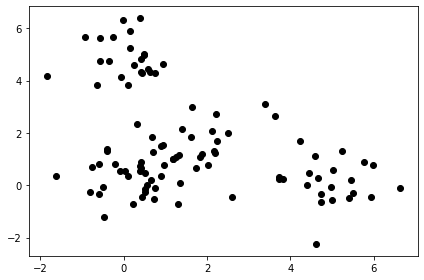

In [16]:
import matplotlib.pyplot as plt

def generate_data(n_data, means, covariances, weights):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
   
    return data

init_means = np.array([
    [5, 0],
    [1, 1],
    [0, 5]
])

init_covariances = np.array([
    [[.5, 0.], [0, .5]],
    [[.92, .38], [.38, .91]],
    [[.5, 0.], [0, .5]]
])

init_weights = [1 / 4, 1 / 2, 1 / 4]

# generate data
np.random.seed(9)
x = generate_data(100, init_means, init_covariances, init_weights)

plt.plot(x[:, 0], x[:, 1], 'ko')
plt.tight_layout()

Iteration 1 Likelihood:  tensor(-420.7436)
Iteration 2 Likelihood:  tensor(-398.5153)
Iteration 3 Likelihood:  tensor(-377.4285)
Iteration 4 Likelihood:  tensor(-376.1884)
Iteration 5 Likelihood:  tensor(-375.8946)
Iteration 6 Likelihood:  tensor(-375.7987)
Iteration 7 Likelihood:  tensor(-375.7625)
Iteration 8 Likelihood:  tensor(-375.7472)
Iteration 9 Likelihood:  tensor(-375.7399)
Iteration 10 Likelihood:  tensor(-375.7361)
Iteration 11 Likelihood:  tensor(-375.7339)
Iteration 12 Likelihood:  tensor(-375.7324)
Iteration 13 Likelihood:  tensor(-375.7314)
Iteration 14 Likelihood:  tensor(-375.7306)
Iteration 15 Likelihood:  tensor(-375.7300)
Iteration 16 Likelihood:  tensor(-375.7295)
Iteration 17 Likelihood:  tensor(-375.7291)
Iteration 18 Likelihood:  tensor(-375.7287)
Iteration 19 Likelihood:  tensor(-375.7285)
Iteration 20 Likelihood:  tensor(-375.7282)
Iteration 21 Likelihood:  tensor(-375.7280)
Iteration 22 Likelihood:  tensor(-375.7278)
Iteration 23 Likelihood:  tensor(-375.727

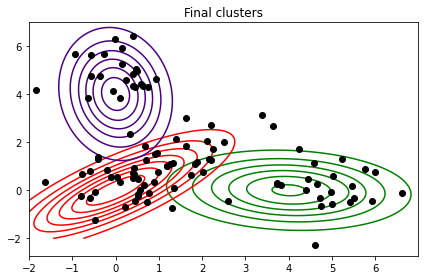

In [17]:
def plot_contours(data, means, covs, title):
    """visualize the gaussian components over the data"""
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko')

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid, colors = col[i])

    plt.title(title)
    plt.tight_layout()

sgmm = DGMM(x)
slls = sgmm.train(0.5, torch.tensor(init_weights), torch.zeros(3, 3), torch.tensor(init_means), torch.tensor(init_covariances))

plot_contours(x, sgmm.mu_c, sgmm.co_c, 'Final clusters')

In [18]:
N = 50

ms = torch.tensor(init_means)
cs = torch.tensor(init_covariances)

d_ws = torch.tensor([.7, .3])
z_ws = torch.tensor([1 / 4, 1 / 2, 1 / 4])
g_ws = torch.tensor([0.0667, 0.1333, 0.2000, 0.1000, 0.2667, 0.2333])

n_clusters, n_features = ms.shape

xx = np.zeros((N, n_features+3))

for i in range(N):
  d = np.random.choice(2, size = 1, p = d_ws)[0]
  
  if d == 0:
    z = np.random.choice(n_clusters, size = 1, p = z_ws)[0]
    xx[i] = np.append(np.random.multivariate_normal(ms[z], cs[z]), [d, z, 0])
  else:
    g = np.random.choice(6, size = 1, p = g_ws)[0]
    
    if g == 0:
      idx = [0,0]
    elif g == 1:
      idx = [0,1]
    elif g == 2:
      idx = [0,2]
    elif g == 3:
      idx = [1,1]
    elif g == 4:
      idx = [1,2]
    else:
      idx = [2,2]

    xx[i] = np.append(np.random.multivariate_normal(ms[idx[0]] + ms[idx[1]], cs[idx[0]] + cs[idx[1]]), (d, idx[0], idx[1]))

In [19]:
xx[:10]

array([[ 4.9649976 ,  5.16977327,  1.        ,  0.        ,  2.        ],
       [ 0.5723591 ,  0.17780533,  0.        ,  1.        ,  0.        ],
       [ 2.36998121,  6.00289239,  1.        ,  1.        ,  2.        ],
       [ 2.01590002,  7.20519234,  1.        ,  1.        ,  2.        ],
       [ 6.57296316, -0.2445153 ,  1.        ,  0.        ,  1.        ],
       [ 5.11564434,  0.24179762,  0.        ,  0.        ,  0.        ],
       [ 2.26110999, 10.39990294,  1.        ,  2.        ,  2.        ],
       [-0.83364405,  0.26567634,  0.        ,  1.        ,  0.        ],
       [ 1.3939186 ,  2.31556212,  0.        ,  1.        ,  0.        ],
       [-1.33570095,  4.05037   ,  0.        ,  2.        ,  0.        ]])

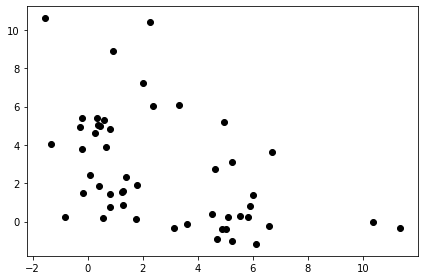

In [57]:
plt.plot(xx[:, 0], xx[:, 1], 'ko')
plt.tight_layout()

In [58]:
gm = torch.tensor([[0.0667, 0.1333, 0.2000], [0, 0.1000, 0.2667], [0, 0, 0.2333]])

#eps * np.identity(X.shape[1])

init_cov = np.array([
    [[.5, 0.], [0, .5]],
    [[1, 0], [0, 1]],
    [[.5, 0.], [0, .5]]
])

ssgmm = DGMM(xx[:,:2], c=3)
sslls = ssgmm.train(0.7, z_ws, gm, torch.tensor(init_means), init_cov, itermax=300)

Iteration 1 Likelihood:  tensor(-210.8993)
Iteration 2 Likelihood:  tensor(-222.7578)
Iteration 3 Likelihood:  tensor(-218.8732)
Iteration 4 Likelihood:  tensor(-218.8773)
Iteration 5 Likelihood:  tensor(-242.7611)
Iteration 6 Likelihood:  tensor(-229.4603)
Iteration 7 Likelihood:  tensor(-224.9884)
Iteration 8 Likelihood:  tensor(-223.3196)
Iteration 9 Likelihood:  tensor(-223.2963)
Iteration 10 Likelihood:  tensor(-224.1621)
Iteration 11 Likelihood:  tensor(-223.4731)
Iteration 12 Likelihood:  tensor(-223.1011)
Iteration 13 Likelihood:  tensor(-222.9003)
Iteration 14 Likelihood:  tensor(-222.9414)
Iteration 15 Likelihood:  tensor(-222.9513)
Iteration 16 Likelihood:  tensor(-222.9339)
Iteration 17 Likelihood:  tensor(-222.9124)
Iteration 18 Likelihood:  tensor(-222.8965)
Iteration 19 Likelihood:  tensor(-222.8862)
Iteration 20 Likelihood:  tensor(-222.8794)
Iteration 21 Likelihood:  tensor(-222.8742)
Iteration 22 Likelihood:  tensor(-222.8701)
Iteration 23 Likelihood:  tensor(-222.866

In [59]:
ssgmm.pi_d

tensor(0.4544)

In [62]:
sum(xx[:,2] == 0)/50

0.66

In [61]:
ssgmm.pi_c

tensor([0.4811, 0.0000, 0.5189])

In [65]:
print(sum((xx[:,2] == 0) & (xx[:,3] == 0))/N)
print(sum((xx[:,2] == 0) & (xx[:,3] == 1))/N)
print(sum((xx[:,2] == 0) & (xx[:,3] == 2))/N)

0.2
0.26
0.2


In [66]:
ssgmm.pi_cc

tensor([[0.1552, 0.0738, 0.3584],
        [0.0000, 0.0000, 0.1355],
        [0.0000, 0.0000, 0.2772]])

In [67]:
print(sum((xx[:,2] == 1) & (xx[:,3] == 0) & (xx[:,3] == 0)))
print(sum((xx[:,2] == 1) & (xx[:,3] == 0) & (xx[:,3] == 1)))
print(sum((xx[:,2] == 1) & (xx[:,3] == 0) & (xx[:,3] == 2)))
print(sum((xx[:,2] == 1) & (xx[:,3] == 1) & (xx[:,3] == 1)))
print(sum((xx[:,2] == 1) & (xx[:,3] == 1) & (xx[:,3] == 2)))
print(sum((xx[:,2] == 1) & (xx[:,3] == 2) & (xx[:,3] == 2)))

10
0
0
4
0
3


In [ ]:
### E-step:
## calculate 1) pi_i => d; 2) pi_j => z; 3) pi_jk => gamma
## first compute 2) and 3) and then 1)

r_ij_top = torch.zeros(c, n)
r_ijk_top = torch.zeros(c, c, n)
    
for j in range(c):
  r_ij_top[j] = pi_d * (pi_c[j] * stats.multivariate_normal(mu_c[j], co_c[j]).pdf(X))
  for k in range(c):
    r_ijk_top[j,k] = (1-pi_d) * (pi_cc[j][k] * stats.multivariate_normal(mu_c[j] + mu_c[k], co_c[j] + co_c[k]).pdf(X))

r_ij_bot = torch.sum(r_ij_top, 0) #for 2)
r_ij = r_ij_top / r_ij_bot

r_ijk_bot = torch.sum(torch.sum(r_ijk_top, 0), 0) #for 3)
r_ijk = r_ijk_top / r_ijk_bot

r_i = r_ij_bot / (r_ij_bot + r_ijk_bot) #for 1

## compute log-likelihood
logl = torch.sum(torch.log(r_ij_bot) + torch.log(r_ijk_bot))

## predictions
#d0pred = torch.max(r_ij, 0).indices
#d0pred

#d1pred = torch.zeros(n, 2)
#for i in range(n):
#  d1pred[i,:] = torch.tensor(np.unravel_index(r_ijk[:,:,i].argmax(), r_ijk[:,:,i].shape))
#d1pred

### M-step:

## update pi_d
pi_d = torch.sum(r_i) / n #(one value)

## update pi_c (c values)
n_c = torch.sum(r_i * r_ij, 1) ## number of points in n_c
pi_c = n_c / sum(n_c)
#pi_c = r_i * r_ij / n

## update pi_cc (cxc upper triangular matrix)
n_cc = torch.sum(((1 - r_i) * r_ijk).T, 0).T ## number of points in each n_cc
pi_cc = n_cc / torch.sum(n_cc)
#pi_cc = (1 - r_i) * r_ijk / n

## update mu_cj and sigma_cj
bot1 = 0; bot2 = 0
m_top1 = 0; c_top1 = 0
m_top2 = 0; c_top2 = 0

## note i and j position switch for r_ijk
for j in range(c):

  for i in range(n):
    
    w1 = r_i[i] * r_ij[j,i]
    bot1 += w1
    
    m_top1 += w1 * torch.tensor([X[i,:]])

    top_ker1 = torch.tensor([X[i,:]]) - mu_c[j,:]
    c_top1 += w1 * (top_ker1.T * top_ker1)

    for k in range(c):
      w2 = (1-r_i[i]) * r_ijk[j,k,i]
      bot2 += w2
      
      m_top2 += w2 * (torch.tensor([X[i,:]]) - mu_c[k,:])
      
      top_ker2 = torch.tensor([X[i,:]]) - (mu_c[j,:] + mu_c[k,:])    
      c_top2 += w2 * ((top_ker2.T * top_ker2) - co_c[k,:])

  mu_c[j] = (m_top1 + m_top2) / (bot1 + bot2)
  co_c[j] = (c_top1 + c_top2) / (bot1 + bot2)

In [21]:
class DGMM(object):
  
  def __init__(self, X, c=3):
    self.X = np.asarray(X)
    
    # dimension
    self.n, self.p = X.shape
    self.c = c
  
#  def _init(self):
#    self.r_i = torch.ones(self.n)
#    self.r_ij = torch.ones(self.c, self.n)
#    self.r_ijk = torch.ones(self.c, self.c, self.n)

#    self.n_c = torch.zeros(self.c)
#    self.n_cc = torch.zeros(self.c)

#    self.pi_d = torch.zeros(1)
    #self.pi_c = torch.ones(self.c) / self.c
    #self.pi_cc = torch.triu(torch.ones(self.c, self.c)) / (self.c * self.c)

#    self.pi_c = torch.zeros(self.c)
#    self.pi_cc = torch.ones(self.c, self.c)

#    self.mu_c = torch.zeros(self.c, self.p)
#    self.co_c = torch.zeros(self.c, self.p, self.p)
  
  def _init(self):
    
    self.mu_c = torch.tensor(
          [[6.8500, 3.0737, 5.7421, 2.0711],
           [5.0060, 3.4280, 1.4620, 0.2460],
           [5.9016, 2.7484, 4.3935, 1.4339]])
      
    self.co_c = torch.tensor(
          [[[0.2442, 0.0254, 0.1773, 0.0055],
            [0.0254, 0.0842, 0.0122, 0.0344],
            [0.1773, 0.0122, 0.2387, 0.0253],
            [0.0055, 0.0344, 0.0253, 0.0783]],
           [[0.1242, 0.0992, 0.0164, 0.0103],
            [0.0992, 0.1437, 0.0117, 0.0093],
            [0.0164, 0.0117, 0.0302, 0.0061],
            [0.0103, 0.0093, 0.0061, 0.0111]],
           [[0.2175, 0.0637, 0.1343, 0.0345],
            [0.0637, 0.0878, 0.0549, 0.0290],
            [0.1343, 0.0549, 0.2590, 0.1214],
            [0.0345, 0.0290, 0.1214, 0.0885]]])
      
    self.n_c = torch.tensor([38., 50., 62.])
    self.n_cc = torch.tensor([[10, 20, 30], [0, 15, 40], [0, 0, 35]])

    self.pi_d = .4
    self.pi_c = self.n_c/sum(self.n_c)
    self.pi_cc = self.n_cc/torch.sum(self.n_cc)  

    self.r_i = torch.ones(self.n)
    self.r_ij = torch.ones(self.c, self.n)
    self.r_ijk = torch.ones(self.c, self.c, self.n)

    #kmeans = KMeans(n_clusters=self.k, random_state=0).fit(self.X)
    #self.mu_c = torch.tensor(kmeans.cluster_centers_)
  
    #for j in range(self.k):
    #  indx = kmeans.labels_ == j
    #  d = self.X[indx]
    #  self.n_c[j] = sum(indx)
    #  self.co_c[j] = torch.from_numpy(np.cov(d.T))

  def train(self, itermax=500, tot=1e-5):
    
    self._init() ## need work
    
    llv = [0.0]
    for iter in range(itermax):
      lli = self.estep()
      self.mstep()
      
      print('Iteration', iter + 1, 'Likelihood: ', lli)
        
      if abs(llv[-1] - lli) < tot:
        break 
      
      llv.append(lli)
    return llv[1:]

  def estep(self):

    ### E-step:
    ## input: n, p, c, pi_d, pi_c, pi_cc, mu_c, co_c
    ## output: r_i, r_ij, r_ijk, ll
    ## calculate 1) pi_i => d; 2) pi_j => z; 3) pi_jk => gamma
    ## first compute 2) and 3) and then 1)

    r_ij_top = torch.zeros(self.c, self.n)
    r_ijk_top = torch.zeros(self.c, self.c, self.n)
    
    for j in range(self.c):
      r_ij_top[j] = self.pi_d * (self.pi_c[j] * stats.multivariate_normal(self.mu_c[j], self.co_c[j]).pdf(self.X))
      for k in range(c):
        r_ijk_top[j,k] = (1-self.pi_d) * (self.pi_cc[j,k] * stats.multivariate_normal(self.mu_c[j] + self.mu_c[k], self.co_c[j] + self.co_c[k]).pdf(self.X))

    r_ij_bot = torch.sum(r_ij_top, 0) #for 2)
    self.r_ij = r_ij_top / r_ij_bot

    r_ijk_bot = torch.sum(torch.sum(r_ijk_top, 0), 0) #for 3)
    self.r_ijk = r_ijk_top / r_ijk_bot

    self.r_i = r_ij_bot / (r_ij_bot + r_ijk_bot) #for 1

    ## compute log-likelihood
    logl = torch.sum(torch.log(r_ij_bot) + torch.log(r_ijk_bot))

    ## predictions
    #d0pred = torch.max(r_ij, 0).indices
    #d0pred

    #d1pred = torch.zeros(n, 2)
    #for i in range(n):
    #  d1pred[i,:] = torch.tensor(np.unravel_index(r_ijk[:,:,i].argmax(), r_ijk[:,:,i].shape))
    #d1pred

    return(logl)

  def mstep(self):
    
    ### M-step:
    ## input: n, p, c, r_i, r_ij, r_ijk
    ## output: pi_d, n_c, pi_c, n_cc, pi_cc, mu_c, co_c
    ## update pi_d
    self.pi_d = torch.sum(self.r_i) / self.n #(one value)

    ## update pi_c (c values)
    self.n_c = torch.sum(self.r_i * self.r_ij, 1) ## number of points in n_c
    self.pi_c = self.n_c / sum(self.n_c)
    #pi_c = r_i * r_ij / n

    ## update pi_cc (cxc upper triangular matrix)
    self.n_cc = torch.sum(((1 - self.r_i) * self.r_ijk).T, 0).T ## number of points in each n_cc
    self.pi_cc = self.n_cc / torch.sum(self.n_cc)
    #pi_cc = (1 - r_i) * r_ijk / n

    ## update mu_cj and sigma_cj
    bot1 = 0; bot2 = 0
    m_top1 = 0; c_top1 = 0
    m_top2 = 0; c_top2 = 0

    ## note i and j position switch for r_ijk
    for j in range(self.c):
      
      for i in range(self.n):

        w1 = self.r_i[i] * self.r_ij[j,i]
        bot1 += w1

        m_top1 += w1 * torch.tensor([self.X[i,:]])

        top_ker1 = torch.tensor([self.X[i,:]]) - self.mu_c[j,:]
        c_top1 += w1 * (top_ker1.T * top_ker1)

        for k in range(self.c):
          w2 = (1-self.r_i[i]) * self.r_ijk[j,k,i]
          bot2 += w2

          m_top2 += w2 * (torch.tensor([self.X[i,:]]) - self.mu_c[k,:])

          top_ker2 = torch.tensor([self.X[i,:]]) - (self.mu_c[j,:] + self.mu_c[k,:])    
          c_top2 += w2 * ((top_ker2.T * top_ker2) - self.co_c[k,:])

      self.mu_c[j] = (m_top1 + m_top2) / (bot1 + bot2)
      self.co_c[j] = (c_top1 + c_top2) / (bot1 + bot2)


In [ ]:
class DGMM(object):
  
  def __init__(self, X, c=3):
    self.X = np.asarray(X)
    
    # dimension
    self.n, self.p = X.shape
    self.c = c
  
  def _init(self):
    self.r_i = torch.ones(self.n)
    self.r_ij = torch.ones(self.c, self.n)
    self.r_ijk = torch.ones(self.c, self.c, self.n)

    self.n_c = torch.zeros(self.c)
    self.n_cc = torch.zeros(self.c)

    self.pi_d = torch.ones(1)
    self.pi_c = torch.ones(self.c) / self.c
    self.pi_cc = torch.triu(torch.ones(self.c, self.c)) / (self.c * self.c)

    self.mu_c = torch.ones(self.c, self.p)
    self.co_c = torch.zeros(self.c, self.p, self.p)

  def estep(self):
    
    ### E-step:
    ## calculate 1) pi_i => d; 2) pi_j => z; 3) pi_jk => gamma
    ## first compute 2) and 3) and then 1)
    
    r_ij_top = torch.zeros(self.c, self.n)
    r_ijk_top = torch.zeros(self.c, self.c, self.n)
    
    for j in range(self.c):
      r_ij_top[j] = self.pi_d * (self.pi_c[j] * stats.multivariate_normal(self.mu_c[j], self.co_c[j]).pdf(self.X))
      for k in range(self.c):
        r_ijk_top[j][k] = (1-self.pi_d) * (self.pi_cc[j][k] * stats.multivariate_normal(self.mu_c[j] + self.mu_c[k], self.co_c[j] + self.co_c[k]).pdf(self.X))

    ## for 2)
    #r_ij_top = torch.zeros(c, n)
    #for j in range(c):
    #  r_ij_top[j] = pi_d * (pi_c[j] * stats.multivariate_normal(mu_c[j], co_c[j]).pdf(X))

    r_ij_bot = torch.sum(r_ij_top, 0) #for 1)
    self.r_ij = r_ij_top / r_ij_bot
  
    ## for 3)
    #r_ijk_top = torch.zeros(c, c, n) 
    #for j in range(c):
    #  for k in range(c):
    #    r_ijk_top[j][k] = (1-pi_d) * (pi_cc[j][k] * stats.multivariate_normal(mu_c[j] + mu_c[k], co_c[j] + co_c[k]).pdf(X))

    r_ijk_bot = torch.sum(torch.sum(r_ijk_top, 0), 0) #for 1)
    self.r_ijk = r_ijk_top / r_ijk_bot

    ## for 1)
    self.r_i = r_ij_bot / (r_ij_bot + r_ijk_bot)

    ## compute log-likelihood
    logl = torch.sum(torch.log(r_ij_bot) + torch.log(r_ijk_bot))

    ## predictions
    pred0 = torch.max(self.r_ij, 0).indices
    #d0pred

    pred1 = torch.zeros(self.n, 2)
    for i in range(self.n):
      pred1[i,:] = torch.tensor(np.unravel_index(self.r_ijk[:,:,i].argmax(), self.r_ijk[:,:,i].shape))
    #d1pred

    return(logl, pred0, pred1)

  def mstep(self):

    ### M-step:
  
    ## update pi
    self.pi_d = torch.sum(self.r_i) / n #(one value)
  
    ## update pi_c (c values)
    self.n_c = torch.sum(self.r_i * self.r_ij, 1) ## number of points in n_c
    self.pi_c = self.n_c / sum(self.n_c)
    #pi_c = r_i * r_ij / n
  
    ## update pi_cc (cxc upper triangular matrix)
    self.n_cc = torch.sum(((1 - self.r_i) * self.r_ijk).T, 0).T ## number of points in each n_cc
    self.pi_cc = self.n_cc / torch.sum(self.n_cc)
    #pi_cc = (1 - r_i) * r_ijk / n
  
    ## update mu_cj and sigma_cj
    bot1 = 0; bot2 = 0
    m_top1 = 0; c_top1 = 0
    m_top2 = 0; c_top2 = 0
  
    for j in range(c):
    
      for i in range(n):
        w1 = r_i[i] * r_ij[j,i]
        bot1 += w1
    
        m_top1 += w1 * torch.tensor([X.iloc[i,:]])

        top_ker1 = torch.tensor([X.iloc[i,:]]) - mu_c[j,:]
        c_top1 += w1 * (top_ker1.T * top_ker1)

        for k in range(c):
          w2 = (1-r_i[i]) * r_ijk[j,k,i]
          bot2 += w2
      
          m_top2 += w2 * (torch.tensor([X.iloc[i,:]]) - mu_c[k,:])
      
          top_ker2 = torch.tensor([X.iloc[i,:]]) - (mu_c[j,:] + mu_c[k,:])    
          c_top2 += w2 * ((top_ker2.T * top_ker2) - co_c[k,:])

      self.mu_c[j] = (m_top1 + m_top2) / (bot1 + bot2)
      self.co_c[j] = (c_top1 + c_top2) / (bot1 + bot2)

    #return(pi_d, n_c, pi_c, n_cc, pi_cc, mu_c, co_c)

  


In [ ]:
n = 150

### E-step:
## calculate 1) pi_i => d; 2) pi_j => z; 3) pi_jk => gamma
## first compute 2) and 3) and then 1)

## for 2)
r_ij_top = torch.zeros(c, n) 
for j in range(c):
  r_ij_top[j] = pi_d * (pi_c[j] * stats.multivariate_normal(mu_c[j], co_c[j]).pdf(X))

r_ij_bot = torch.sum(r_ij_top, 0) #for 1)
r_ij = r_ij_top / r_ij_bot

## for 3)
r_ijk_top = torch.zeros(c, c, n) 
for j in range(c):
  for k in range(c):
    r_ijk_top[j][k] = (1-pi_d) * (pi_cc[j][k] * 
                             stats.multivariate_normal(mu_c[j] + mu_c[k], co_c[j] + co_c[k]).pdf(X))

r_ijk_bot = torch.sum(torch.sum(r_ijk_top, 0), 0) #for 1)
r_ijk = r_ijk_top / r_ijk_bot

r_i = r_ij_bot / (r_ij_bot + r_ijk_bot)

## compute log-likelihood
logl = torch.sum(torch.log(r_ij_bot) + torch.log(r_ijk_bot))

## predictions
d0pred = torch.max(r_ij, 0).indices
#d0pred

d1pred = torch.zeros(n, 2)
for i in range(n):
  d1pred[i,:] = torch.tensor(np.unravel_index(r_ijk[:,:,i].argmax(), r_ijk[:,:,i].shape))
#d1pred

### E-step:

## update pi
pi_d = torch.sum(r_i) / n #(one value)

## update pi_c (c values)
n_c = torch.sum(r_i * r_ij, 1) ## number of points in n_c
pi_c = n_c / sum(n_c)
#pi_c = r_i * r_ij / n

## update pi_cc (cxc upper triangular matrix)
n_cc = torch.sum(((1 - r_i) * r_ijk).T, 0).T ## number of points in each n_cc
pi_cc = n_cc / torch.sum(n_cc)
#pi_cc = (1 - r_i) * r_ijk / n

## update mu_cj and sigma_cj
bot1 = 0; bot2 = 0
m_top1 = 0; c_top1 = 0
m_top2 = 0; c_top2 = 0

for j in range(c):

  for i in range(n):
    
    w1 = r_i[i] * r_ij[j,i]
    bot1 += w1
    
    m_top1 += w1 * torch.tensor([X.iloc[i,:]])

    top_ker1 = torch.tensor([X.iloc[i,:]]) - mu_c[j,:]
    c_top1 += w1 * (top_ker1.T * top_ker1)

    for k in range(c):
      w2 = (1-r_i[i]) * r_ijk[j,k,i]
      bot2 += w2
      
      m_top2 += w2 * (torch.tensor([X.iloc[i,:]]) - mu_c[k,:])
      
      top_ker2 = torch.tensor([X.iloc[i,:]]) - (mu_c[j,:] + mu_c[k,:])    
      c_top2 += w2 * ((top_ker2.T * top_ker2) - co_c[k,:])

  mu_c[j] = (m_top1 + m_top2) / (bot1 + bot2)
  co_c[j] = (c_top1 + c_top2) / (bot1 + bot2)

In [ ]:
## update mu_cj
top1 = 0; bot1 = 0
top2 = 0; bot2 = 0
for j in range(c):

  for i in range(n):
    
    w1 = r_i[i] * r_ij[j,i]
    bot1 += w1
    top1 += torch.tensor([X.iloc[i,:]]) * w1
    
    for k in range(c):
      w2 = (1-r_i[i]) * r_ijk[j,k,i]
      bot2 += w2
      top2 += (torch.tensor([X.iloc[i,:]]) - mu_c[k,:]) * w2
      
  mu_c[j] = (top1 + top2) / (bot1 + bot2)

## update sigma_cj
top1 = 0; bot1 = 0
top2 = 0; bot2 = 0
for j in range(c):
  
  for i in range(n):
    top_ker1 = torch.tensor([X.iloc[i,:]]) - mu_c[j,:]
    w1 = r_i[i] * r_ij[j,i]
    bot1 += w1
    top1 += w1 * (top_ker1.T * top_ker1)

    top_ker2 = torch.tensor([X.iloc[i,:]]) - (mu_c[j,:] + mu_c[k,:])    
    for k in range(c):
      w2 = (1-r_i[i]) * r_ijk[j,k,i]
      bot2 += w2
      top2 += w2 * ((top_ker2.T * top_ker2) - co_c[k,:])
  
  co_c[j] = (top1 + top2) / (bot1 + bot2)

In [ ]:
top1 = 0; bot1 = 0
top2 = 0; bot2 = 0
for j in range(c):
  
  for i in range(n):
    top_ker1 = torch.tensor([X.iloc[i,:]]) - mu_c[j,:]
    w1 = r_i[i] * r_ij[j,i]
    bot1 += w1
    top1 += w1 * (top_ker1.T * top_ker1)

    top_ker2 = torch.tensor([X.iloc[i,:]]) - (mu_c[j,:] + mu_c[k,:])    
    for k in range(c):
      w2 = (1-r_i[i]) * r_ijk[j,k,i]
      bot2 += w2
      top2 += w2 * ((top_ker2.T * top_ker2) - co_c[k])
  co_c[j] = (top1 + top2) / (bot1 + bot2)

In [ ]:
## EM algorithm
llv = [0.0]
for iter in range(itermax):
  lli = estep()
  mstep()
      
  print('Iteration', iter + 1, 'Likelihood: ', lli)
        
  if abs(llv[-1] - lli) < 1e-4:
    break 
      
  llv.append(lli)
